In [1]:
import pandas as pd
from random import gauss as gs, uniform as uni, seed
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import re 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [2]:
with open('Downloads/README.txt') as f:
    lines = f.readlines()

In [3]:
lines

['Summary\n',
 '=======\n',
 '\n',
 'This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.\n',
 '\n',
 'Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.\n',
 '\n',
 'The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.\n',
 '\n',
 'This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.\n',

## Important Read Me Notes

#### This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.\n',


#### 'Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).\n',

# EDA 

## ________________________________

## Movies CSV 

### I noticed that the value of "movieId is one for all of the movies in this particular data set and ther are no duplicates there fore every movie is labled with its generes and as movie ID has one value that translates to other data sets we are goin to assume that the number 9742 is the amount of movies in this data set 

### Want to potentially drop the index for a more clean data set

### no null values. 

### multiple generes for some movies what are we going to do with that. 

### gotta seperate the years from the title. 


In [4]:
movies=pd.read_csv('Downloads/movies.csv')

In [5]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Removing the year from the movies

In [6]:
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))','')
movies['title'] = movies['title'].apply(lambda x: x.strip())

<ipython-input-6-8d3ff453c498>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))','')


### I already Know working with genres can be a bit difficcult due to the amount and the sparsity so I will just drop it and focus on the movies themselves

In [7]:
movies.drop(columns = ['genres'], inplace = True)

In [8]:
#to make all titles actually one case 

movies['title'] = movies['title'].str.lower()


### Movie dataset has

### movieId - once the recommendation is done, we get list of all similar movieId and get the title for each movie from this dataset.
### Titles to the moves we wll use thiis for relationship

# _____________

##  Links 

#### Startin with the tmbid column as Movie ID is the same across the board I do not need an additional Identifier if I am basing my recomendations on the ratins of the movies

#### Also I guess I don't really need this particular data set at all as it has nothing of use

In [9]:
links = pd.read_csv('Downloads/links.csv')
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


## Ratings 

### 91,000 More rows than my movie set. as there are duplicates Each user gave a vote on thee rating of the movie ID 

### So Now I either have to deccide what to do with the ratings do  I put a mean. or do I group by ? 

In [10]:
ratings = pd.read_csv('Downloads/ratings.csv')
ratings
ratings.drop(columns = 'timestamp')

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### Ratings dataset has

### userId - unique for each user
### movieId - using this feature ,we take the title of the movie from movies dataset
### rating - Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

## Item based filtering
#### This approach is mostly preferred since the movie don't change much. We can rerun this model once a week unlike User based where we have to frequently run the model.

In [11]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
highest_vote_count =ratings.groupby(['movieId'])['rating'].agg('count')
highest_vote_count.sort_values(ascending = False).head(20)

movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
2959    218
1       215
1196    211
50      204
2858    204
47      203
780     202
150     201
1198    200
4993    198
Name: rating, dtype: int64

In [14]:
movies[movies['movieId']==356]

,movieId,title
314,356,forrest gump


### We will reduce the noise by adding some filters and qualify the movies for the final dataset.

#### To qualify a movie, minimum 10 users should have voted a movie.
#### To qualify a user, minimum 50 movies should have voted by the user.To qualify a movie, a minimum of 10 users should have voted a movie.


In [15]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [16]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 70.5].index,:] 
#eliminating the movies in which at least ten people didn't vote on 

In [17]:
 ratings.groupby('userId')['rating'].agg('count').quantile(.45)

60.0

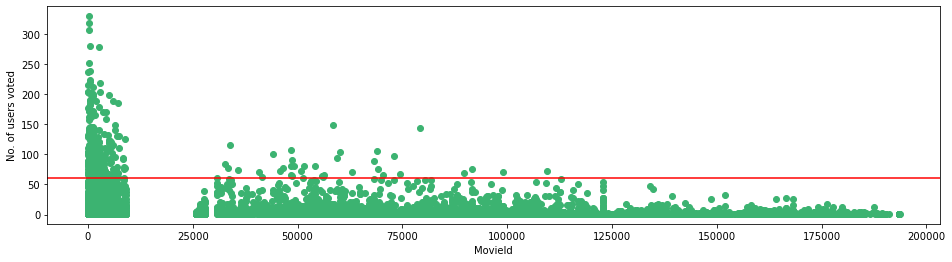

In [18]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=60,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

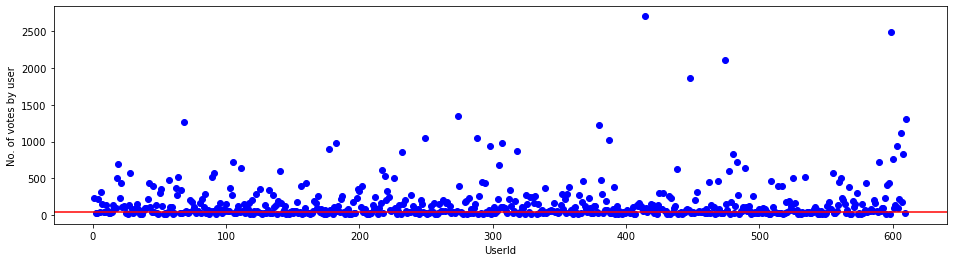

In [19]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='blue')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [20]:
#eliminating the users who did not vote on 50 or more movies
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
10,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
16,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,...,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72998,0.0,0.0,0.0,0.0,2.5,0.0,3.0,0.0,0.0,4.0,...,0.0,4.0,0.0,0.0,0.0,3.5,3.0,0.0,0.0,4.5
79132,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.0,4.5,4.5,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
91529,0.0,0.0,0.0,0.0,5.0,0.0,2.0,4.5,0.0,4.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5


## To reduce the sparsity we use csr_matric scipy lib.

In [21]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

### We use cosine distance metric which is very fast and preferable than pearson coefficient. 

In [22]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=15, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [23]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input its all lower case :)"

In [24]:
get_movie_recommendation('toy story')

,Title,Distance
1,shrek,0.381472
2,star wars: episode iv - a new hope,0.380789
3,toy story 2,0.371637
4,forrest gump,0.356542
5,jurassic park,0.334884


# Lets expand 

### Lets try using th pearson correlation for user ratings and user input

In [25]:
user_Input = [
            {'title': 'breakfast club, the', 'rating': float(input(''))},
            {'title': 'toy story', 'rating': float(input(''))},
            {'title': 'jumanji', 'rating': float(input(''))},
            {'title': 'jurassic park', 'rating': float(input(''))},
            {'title': 'deadpool', 'rating': float(input(''))}]
inputMovies = pd.DataFrame(user_Input)
inputMovies

3
4
1
3
5


,title,rating
0,"breakfast club, the",3.0
1,toy story,4.0
2,jumanji,1.0
3,jurassic park,3.0
4,deadpool,5.0


In [26]:
inputId = movies[movies['title'].isin(inputMovies['title'].tolist())]
inputMovies = pd.merge(inputId, inputMovies)

In [27]:
inputMovies

,movieId,title,rating
0,1,toy story,4.0
1,2,jumanji,1.0
2,480,jurassic park,3.0
3,1968,"breakfast club, the",3.0
4,122904,deadpool,5.0


### Who are the users who have seen the same movies that I have voted on? 

In [28]:
users_ = ratings[ratings['movieId'].isin(inputMovies['movieId'].tolist())]

In [29]:
users_['userId'].value_counts() #that

298    5
68     5
525    5
448    5
414    5
      ..
386    1
154    1
389    1
394    1
302    1
Name: userId, Length: 381, dtype: int64

In [30]:
# Grouping the uers togeathr
grouped_users = users_.groupby(['userId'])

In [31]:
#users with the most movies in common with the input will have priority 
userSubsetGroup = sorted(grouped_users, key=lambda x: len(x[1]), reverse = True)

In [32]:
userSubsetGroup[0][1] #viewing my number one watcer

,userId,movieId,rating,timestamp
10360,68,1,2.5,1158531426
10361,68,2,2.5,1158532776
10454,68,480,3.5,1158531200
10679,68,1968,3.0,1158531622
11607,68,122904,4.0,1526947540


In [33]:
userSubsetGroup = userSubsetGroup[0:100] #limit the amount of filtering for users time sake 

In [34]:
#storing the pearson correlation in a dictionary

pearsonCorrelationDict = {}

#for all users in our user_ variable 
for name, group in userSubsetGroup: 
    #sorting input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    
    #Get then number of movies watched for the formula
    nRatings = len(group)
    
  
    #get the rating for the movies that we have in comon
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    

        
    #storing the reviews in a list
    tempRatingList = temp_df['rating'].tolist()
    
    tempGrouplist = group['rating'].tolist()
    
    #pearson correlation 
    pearsonCorrelationDict[name] = pearsonr(tempRatingList,tempGrouplist)

C:\Users\metropolitanparkapts\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [35]:
pearsonCorrelationDict.items() #viewing my results

dict_items([(68, (0.620505227994023, 0.26407490940411943)), (298, (0.5345224838248487, 0.3533874662886981)), (414, (0.47673129462279606, 0.4168545738501419)), (448, (0.6407116072277477, 0.2441086555666262)), (525, (0.04029114820126899, 0.948713600135929)), (561, (-0.6398358790761189, 0.24496514818733509)), (599, (0.5026155365907202, 0.3881206974492674)), (18, (0.87831006565368, 0.12168993434632003)), (19, (0.20751433915982237, 0.7924856608401776)), (21, (-0.09759000729485333, 0.9024099927051467)), (91, (0.5739640213948521, 0.42603597860514786)), (103, (nan, nan)), (135, (0.64888568452305, 0.35111431547695005)), (141, (0.8528028654224417, 0.14719713457755834)), (177, (0.6622661785325218, 0.3377338214674782)), (202, (0.13245323570650436, 0.8675467642934956)), (217, (0.9271726499455307, 0.07282735005446928)), (219, (0.7181848464596078, 0.2818151535403922)), (226, (0.6225430174794669, 0.37745698252053306)), (249, (0.6831300510639733, 0.3168699489360267)), (274, (0.6882472016116852, 0.31175

In [36]:
pearsondf = pd.DataFrame.from_dict(pearsonCorrelationDict, orient = 'index')
pearsondf = pearsondf[[0]]

In [37]:
pearsondf.columns= ['SimilartyIndex']
pearsondf['userId'] = pearsondf.index
pearsondf.index = range(len(pearsondf))
pearsondf

,SimilartyIndex,userId
0,0.620505,68
1,0.534522,298
2,0.476731,414
3,0.640712,448
4,0.040291,525
...,...,...
95,-1.000000,597
96,-1.000000,600
97,0.327327,605
98,-0.500000,606


### getting the users who are most similar to my ratings

In [38]:
top_users = pearsondf.sort_values(by = 'SimilartyIndex', ascending = False)[0:50]

In [39]:
top_users.head()

,SimilartyIndex,userId
62,1.0,275
88,1.0,527
65,1.0,282
77,1.0,425
57,1.0,212


### Pearson correlation is going to be our weight but first we hve to get the movies watch by users in the df an then stor there correlation in a new column of similarity idex

In [40]:
top_use_ratings = top_users.merge(ratings, left_on = 'userId', right_on= 'userId', how='inner')

In [41]:
top_use_ratings.drop(columns= ['timestamp'])

,SimilartyIndex,userId,movieId,rating
0,1.0,275,1,5.0
1,1.0,275,17,5.0
2,1.0,275,21,5.0
3,1.0,275,25,3.0
4,1.0,275,32,5.0
...,...,...,...,...
27048,0.5,66,8784,4.5
27049,0.5,66,8798,4.5
27050,0.5,66,8874,5.0
27051,0.5,66,8961,4.0


In [42]:
# Now we multiply the movie rating by the similarty inde and then divide by the sum of weights

In [43]:
top_use_ratings['weighted_rating'] = top_use_ratings['SimilartyIndex'] * top_use_ratings['rating']
top_use_ratings.tail()

,SimilartyIndex,userId,movieId,rating,timestamp,weighted_rating
27048,0.5,66,8784,4.5,1104644101,2.25
27049,0.5,66,8798,4.5,1097803995,2.25
27050,0.5,66,8874,5.0,1112589663,2.50
27051,0.5,66,8961,4.0,1104644077,2.00
27052,0.5,66,51255,4.0,1182723476,2.00


### I decided to make sure that the the movies had enough votes prior to considering them in my reccomedation so I'll make a new data frame that only has votes in a certain quantile. 

In [44]:
sum_rating = top_use_ratings.groupby('movieId').sum()[['SimilartyIndex','weighted_rating']]
sum_rating.columns = ['sum_similarityIndex', 'sum_wightedRating']
sum_rating.head()

,sum_similarityIndex,sum_wightedRating
movieId,,
1,33.584372,141.306298
2,29.153645,88.297093
3,8.975553,26.934931
4,0.944911,1.889822
5,6.536552,17.277163


In [45]:
reccomendation_df = pd.DataFrame()
#getting the weighted avg
reccomendation_df['weighted_average rec score'] = sum_rating['sum_wightedRating']/sum_rating['sum_similarityIndex']
reccomendation_df['movieId']= sum_rating.index
reccomendation_df.head()

,weighted_average rec score,movieId
movieId,,
1,4.207502,1
2,3.028681,2
3,3.000922,3
4,2.000000,4
5,2.643162,5


In [46]:
reccomendation_df = reccomendation_df.sort_values(by='weighted_average rec score', ascending = False)
reccomendation_df.head()

,weighted_average rec score,movieId
movieId,,
38304,5.0,38304
74282,5.0,74282
8580,5.0,8580
5938,5.0,5938
26073,5.0,26073


## Then we just add our reccomendatios to the list ! 

In [48]:
movies.loc[movies['movieId'].isin(reccomendation_df.head(10)['movieId'].tolist())]

,movieId,title
3067,4116,hollywood shuffle
3661,5039,dragonslayer
4128,5938,deathtrap
4344,6345,"chorus line, a"
5236,8580,into the woods
5448,26073,"human condition iii, the (ningen no joken iii)"
6022,38304,no direction home: bob dylan
7252,74282,anne of green gables: the sequel (a.k.a. anne ...
8154,102217,bill hicks: revelations
8986,138966,nasu: summer in andalusia
